In [1]:
# dataframe management
import pandas as pd             

# numerical computation
import numpy as np

import re

# visualization library
import seaborn as sns
sns.set(style="white", color_codes=True)
sns.set_context(rc={"font.family":'sans',"font.size":24,"axes.titlesize":24,"axes.labelsize":24})   


# import matplotlib and allow it to plot inline
import matplotlib.pyplot as plt
%matplotlib inline

# seaborn can generate several warnings, we ignore them
import warnings 
warnings.filterwarnings("ignore")

from bokeh.layouts import gridplot
from bokeh.plotting import figure

from bokeh.io import output_notebook, show
from bokeh.models import ColumnDataSource
output_notebook()

from datetime import datetime, timedelta, date
from scipy.stats import skew
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, ElasticNet, Lasso, LassoCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.datasets import load_boston

import statsmodels.api as sm


Loading BokehJS ...

# Functions definitions

In [2]:
def toDate(x):
    parts = [int(el) for el in x.split("/")]
    return date(parts[2], parts[1], parts[0])

def r2_cv(model, sales_train, y, random_state=12345678):
    r2= cross_val_score(model, sales_train, y, scoring="r2", cv =KFold(10, shuffle=True, random_state=random_state)) 
    return(r2)

def rmse_cv(model, sales_train, y, random_state=12345678):
    rmse= np.sqrt(-cross_val_score(model, sales_train, y, scoring="neg_mean_squared_error", cv =KFold(10, shuffle=True, random_state=random_state)))
    return(rmse)

def RegionError(region, data):
    d = data[data[region] == 1][["StoreID","Month","NumberOfSales","NumberOfPredictedSales"]].groupby(["StoreID","Month"]).agg("sum")
    res = abs(d["NumberOfSales"]-d["NumberOfPredictedSales"]).agg("sum")
    return res / d["NumberOfSales"].agg("sum")

def q(col, quant, f):
    t = sales[col].quantile(quant)
    print(f'col {col} at {quant}-th quantile => {t}')
    sales.loc[f(sales[col], t), col] = t
    
def getFilterRegion(cluster, data):
    filterRegion = data[cluster[0]] == 1
    for region in cluster[1:]:
        filterRegion = ((filterRegion) | (data[region]==1))
    return filterRegion

def getColsMatching(data, oldCol):
    return [col for col in data.columns if re.match(r"("+oldCol+"_)(\d)", col)]

def dedummify(data, oldCol):
    return data[getColsMatching(data,oldCol)].idxmax(axis=1).apply(lambda x : x.split("_")[-1])

def firstStepGetModelTrained(cluster, train):
    
    #Get only the data for the required cluster in train and test set
    train_region_label= train.loc[getFilterRegion(cluster,train)]
    
    #removing the region columns in order to force the tree alghoritm to do not split for regions
    cols_not_for_step1 = ['Region_PopulationK','Region_AreaKM2','Region_GDP',*cluster]
    train_region_columns = train_region_label[cols_not_for_step1]
    train_region_label=train_region_label.drop(columns=cols_not_for_step1)
    
    train_x_region_label_step1 = train_region_label.drop(columns=['NumberOfSales','NumberOfCustomers'])
    train_y_region_label_step1 = pd.DataFrame(data = train_region_label['NumberOfCustomers'])
    
    #First model predicting NumberOfCustomers
    model_simple = RandomForestRegressor()
    model_simple = model_simple.fit(train_x_region_label_step1, train_y_region_label_step1)
    return (model_simple, cols_not_for_step1)

def secondStepGetModelTrained(train):
    train_x_step2 = train.drop(columns=['NumberOfSales'])
    train_y_step2 = pd.DataFrame(data = train['NumberOfSales']) 
    cols_for_step2 = [*getColsMatching(train,"Month"), *getColsMatching(train,"Region"),'NumberOfCustomers','Region_AreaKM2','HasPromotions','IsHoliday','Region_GDP', "StoreID"]
    train_x_step2 = train_x_step2[cols_for_step2]
    
    #STEP2
    model_simple_step2 = RandomForestRegressor()
    model_simple_step2 = model_simple_step2.fit(train_x_step2, train_y_step2)
    return (model_simple_step2, cols_for_step2)

def getModelsTrained(clusters, train):
    models = {}
    for cluster in clusters:
        models[str(cluster)] = firstStepGetModelTrained(cluster, train)
    # Prepare data for step2
    return models, secondStepGetModelTrained(train)


# Read input data

In [3]:
# Reading the data
sales =pd.read_csv('train.csv')
#sales = sales.append(pd.read_csv('test.csv'))
# Removing tuples where stores are closed
sales = sales[sales['IsOpen'] == 1]
# Converting to category columns that are labels
for el in ["StoreID", "Region"]:
    sales[el] = sales[el].astype("category")

In [4]:
nulls = sales.isnull().sum()
sorted([(x,y) for (x,y) in zip(nulls.index, nulls) if y>0], key=lambda x: x[1], reverse=True)

[('Max_Gust_SpeedKm_h', 341404),
 ('Events', 103661),
 ('CloudCover', 34057),
 ('Max_VisibilityKm', 9258),
 ('Mean_VisibilityKm', 9258),
 ('Min_VisibilitykM', 9258)]

We see that Max_Gust_SpeedKm_h has 409947 missing values. We decided not to impute it.

Let's start with imputation of "Events"

In [5]:
null_Events = sales['Events'].isnull()
event_missing = sales[null_Events]
event_missing.describe()

,IsHoliday,IsOpen,HasPromotions,NearestCompetitor,NumberOfCustomers,NumberOfSales,Region_AreaKM2,Region_GDP,Region_PopulationK,CloudCover,...,Mean_TemperatureC,Mean_VisibilityKm,Mean_Wind_SpeedKm_h,Min_Dew_PointC,Min_Humidity,Min_Sea_Level_PressurehPa,Min_TemperatureC,Min_VisibilitykM,Precipitationmm,WindDirDegrees
count,103661.000000,103661.0,103661.000000,103661.000000,103661.000000,103661.000000,103661.000000,103661.000000,103661.000000,80397.000000,...,103661.000000,94779.000000,103661.000000,103661.000000,103661.000000,103661.000000,103661.000000,94779.000000,103661.000000,103661.000000
mean,0.001042,1.0,0.459179,8601.390619,314.641910,4893.577276,11435.271770,13711.770926,3467.389500,4.989340,...,11.545769,15.176421,11.082558,3.092774,40.196747,1015.171096,6.551538,10.586121,0.003920,134.812292
std,0.032261,0.0,0.498333,12222.596970,159.283348,2238.517426,8284.862826,2736.202628,2694.401824,2.233223,...,7.492758,6.648346,5.112519,6.093297,18.033663,7.151478,6.591203,6.138289,0.087722,103.812782
min,0.000000,1.0,0.000000,47.000000,0.000000,0.000000,344.000000,9893.000000,816.000000,0.000000,...,-11.000000,2.000000,3.000000,-17.000000,10.000000,991.000000,-12.000000,0.000000,0.000000,-1.000000
25%,0.000000,1.0,0.000000,1116.000000,215.000000,3375.000000,7215.000000,11849.000000,1293.000000,3.000000,...,6.000000,10.000000,6.000000,-2.000000,25.000000,1011.000000,1.000000,8.000000,0.000000,46.000000
50%,0.000000,1.0,0.000000,3614.000000,280.000000,4461.000000,9337.000000,13155.000000,1892.000000,5.000000,...,12.000000,13.000000,10.000000,3.000000,37.000000,1015.000000,7.000000,10.000000,0.000000,124.000000
75%,0.000000,1.0,1.000000,10593.000000,372.000000,5918.000000,15566.000000,15931.000000,5727.000000,7.000000,...,18.000000,19.000000,13.000000,8.000000,52.000000,1020.000000,12.000000,10.000000,0.000000,216.000000
max,1.000000,1.0,1.000000,85070.000000,2206.000000,26641.000000,32221.000000,23931.000000,8146.000000,8.000000,...,30.000000,31.000000,34.000000,18.000000,100.000000,1038.000000,23.000000,31.000000,4.060000,360.000000


In [6]:
sales['Events'].value_counts()

Rain                           171189
Fog                             56323
Fog-Rain                        41804
Rain-Thunderstorm               18116
Rain-Snow                       14576
Snow                            12541
Fog-Rain-Thunderstorm            6545
Fog-Snow                         2469
Fog-Rain-Snow                    2364
Thunderstorm                     1298
Rain-Hail                        1148
Rain-Snow-Hail                    513
Fog-Rain-Snow-Hail                231
Rain-Snow-Hail-Thunderstorm       193
Fog-Rain-Hail-Thunderstorm        178
Fog-Snow-Hail                     169
Fog-Rain-Hail                     168
Fog-Thunderstorm                  157
Snow-Hail                         134
Rain-Snow-Thunderstorm            131
Rain-Hail-Thunderstorm             50
Name: Events, dtype: int64

By this, we discovered that when Event is null the weather is good, from the fact that Precipitationmm mean is almost 0.
Furthermore, all the labels of Events are related to bad weather, that means that when no precipitation occurs the label is null.
We will impute Event by replacing the missing values with "Not Specified" (later).

Now we impute "CloudCover", making a distinction when it misses along with Events and when it misses on its own.

In [7]:
null_Events = sales['Events'].isnull()
null_CloudCover = sales['CloudCover'].isnull()
cloudcover_missing = sales[(null_Events)]
null_Events = sales['Events'].isnull()
event_missing = sales[null_Events]
event_cc_missing = sales[null_CloudCover & null_Events]

cloudcover_missing.shape, event_missing.shape, event_cc_missing.shape 

((103661, 36), (103661, 36), (23264, 36))

There are 28k tuples where both "Events" and "CloudCover" are missing, that means that the weather should be good.
for the remaining (41k-28k) (i.e. where "Events" is not null!) tuples we impute the CloudCoverage.

In [8]:
event_notmissing_cc_missing = sales[null_CloudCover & ~null_Events]
#computing mean where CloudCover is not null
mean_CC = sales["CloudCover"].mean()
event_notmissing_cc_missing["CloudCover"] = event_notmissing_cc_missing["CloudCover"].fillna(mean_CC)
sales = pd.concat([sales[~null_CloudCover | null_Events], event_notmissing_cc_missing])

Then, we impute the remaining rows with CloudCover missing

In [9]:
null_Events = sales['Events'].isnull()
CloudyButNotEvent = sales[null_Events]
#there are some tuples with no Events but with the attribute CloudCover

In [10]:
null_cloudCover = sales[sales['CloudCover'].isnull()]
mean_cloudCover = sales["CloudCover"].mean()
null_cloudCover["CloudCover"] = null_cloudCover["CloudCover"].fillna(mean_cloudCover)

sales = pd.concat([sales[~sales['CloudCover'].isnull()], null_cloudCover])

Now, we impute min,max,mean_VisibilityKm. 

In [11]:
# checking if are all the same rows where visibility data are missing => yes, they are
sales[["Max_VisibilityKm", "Mean_VisibilityKm", "Min_VisibilitykM"]].count()

Max_VisibilityKm     424700
Mean_VisibilityKm    424700
Min_VisibilitykM     424700
dtype: int64

In [12]:
null_visibility = sales[sales['Max_VisibilityKm'].isnull()]
mean_vis_max = sales["Max_VisibilityKm"].mean()
mean_vis_mean = sales["Mean_VisibilityKm"].mean()
mean_vis_min = sales["Min_VisibilitykM"].mean()

null_visibility["Max_VisibilityKm"] = null_visibility["Max_VisibilityKm"].fillna(mean_vis_max)
null_visibility["Mean_VisibilityKm"] = null_visibility["Mean_VisibilityKm"].fillna(mean_vis_mean)
null_visibility["Min_VisibilitykM"] = null_visibility["Min_VisibilitykM"].fillna(mean_vis_min)

sales = pd.concat([sales[~sales['Max_VisibilityKm'].isnull()], null_visibility])

Finally, we impute "Events".

In [13]:
sales = sales.replace(np.nan,'NotSpecified', regex=True)


# Dealing with outliers

In [14]:
sales.quantile(.99).sort_values(ascending=False).head(20)

NearestCompetitor             59199.0
Region_AreaKM2                32221.0
Region_GDP                    23931.0
NumberOfSales                 12460.0
Region_PopulationK             8146.0
StoreID                        1741.0
Max_Sea_Level_PressurehPa      1036.0
Mean_Sea_Level_PressurehPa     1033.0
Min_Sea_Level_PressurehPa      1031.0
NumberOfCustomers               886.0
WindDirDegrees                  353.0
Max_Humidity                    100.0
Mean_Humidity                    99.0
Min_Humidity                     93.0
Max_Wind_SpeedKm_h               50.0
Max_TemperatureC                 32.0
Max_VisibilityKm                 31.0
Mean_VisibilityKm                30.0
Min_VisibilitykM                 29.0
Mean_Wind_SpeedKm_h              29.0
Name: 0.99, dtype: float64

In [15]:
q("NearestCompetitor", .95, lambda x, y: x > y)
q("Precipitationmm", .95, lambda x, y: x > y)
q("Max_Wind_SpeedKm_h", .95, lambda x,y: x > y)
q("Max_Wind_SpeedKm_h", .03, lambda x,y: x < y)
q("Max_TemperatureC", .95, lambda x,y: x > y)
q("Max_TemperatureC", .03, lambda x,y: x < y)
q("Min_TemperatureC", .95, lambda x,y: x > y)
q("Min_TemperatureC", .03, lambda x,y: x < y)
q("Mean_Dew_PointC", .95, lambda x,y: x > y)
q("Mean_Dew_PointC", .05, lambda x,y: x < y)
q("Mean_Dew_PointC", .95, lambda x,y: x > y)
q("Mean_Dew_PointC", .05, lambda x,y: x < y)
q("Mean_Humidity", .95, lambda x,y: x > y)
q("Mean_Humidity", .03, lambda x,y: x < y)
q("Min_VisibilitykM", .95, lambda x,y: x > y)
q("Min_Humidity", .03, lambda x,y: x < y)
q("Min_Humidity", .95, lambda x,y: x > y)
q("Mean_Wind_SpeedKm_h", .95, lambda x,y: x > y)
q("Mean_TemperatureC", .03, lambda x,y: x < y)
q("Mean_TemperatureC", .95, lambda x,y: x > y)
q("Mean_VisibilityKm", .05, lambda x,y: x < y)
q("Mean_VisibilityKm", .95, lambda x,y: x > y)

col NearestCompetitor at 0.95-th quantile => 31794.0
col Precipitationmm at 0.95-th quantile => 5.08
col Max_Wind_SpeedKm_h at 0.95-th quantile => 37.0
col Max_Wind_SpeedKm_h at 0.03-th quantile => 11.0
col Max_TemperatureC at 0.95-th quantile => 28.0
col Max_TemperatureC at 0.03-th quantile => 0.0
col Min_TemperatureC at 0.95-th quantile => 16.0
col Min_TemperatureC at 0.03-th quantile => -5.0
col Mean_Dew_PointC at 0.95-th quantile => 15.0
col Mean_Dew_PointC at 0.05-th quantile => -3.0
col Mean_Dew_PointC at 0.95-th quantile => 15.0
col Mean_Dew_PointC at 0.05-th quantile => -3.0
col Mean_Humidity at 0.95-th quantile => 94.0
col Mean_Humidity at 0.03-th quantile => 49.0
col Min_VisibilitykM at 0.95-th quantile => 11.0
col Min_Humidity at 0.03-th quantile => 19.0
col Min_Humidity at 0.95-th quantile => 84.0
col Mean_Wind_SpeedKm_h at 0.95-th quantile => 23.0
col Mean_TemperatureC at 0.03-th quantile => -2.0
col Mean_TemperatureC at 0.95-th quantile => 21.0
col Mean_VisibilityKm at 0.

# Normalization of Numerical Variables

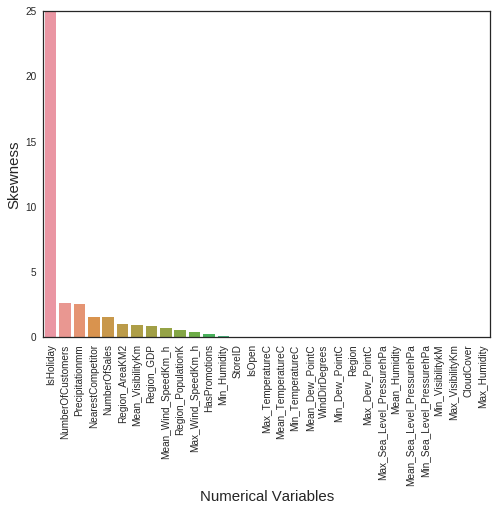

In [16]:
# take the numerical features
numeric_feats = sales.dtypes[sales.dtypes != "object"].index
# compute the skewness but only for non missing variables (we already imputed them but just in case ...)
skewed_feats = sales[numeric_feats].apply(lambda x: skew(x.dropna()))

skewness = pd.DataFrame({"Variable":skewed_feats.index, "Skewness":skewed_feats.data})
# select the variables with a skewness above a certain threshold
skewness = skewness.sort_values('Skewness', ascending=[0])
f, ax = plt.subplots(figsize=(8,6))
plt.xticks(rotation='90')
sns.barplot(x=skewness['Variable'], y=skewness['Skewness'])
plt.ylim(0,25)
plt.xlabel('Numerical Variables', fontsize=15)
plt.ylabel('Skewness', fontsize=15)
plt.title('', fontsize=15)

In [17]:
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.drop(['IsHoliday','NumberOfCustomers', "NumberOfSales"])
sales[skewed_feats.index] = np.log1p(sales[skewed_feats.index])

# Correlation Analysis and Feature Selection

By analyzing the correlation, we see that the following variables do not add any additional information. 
Max_Dew_PointC, Min_Dew_PointC, Max_Sea_Level_PressurehPa, Mean_Sea_Level_PressurehPa, Max_Gust_SpeedKm_h
Finally, we drop 'NumberOfCustomers' because is not present in the submission dataset.

In [18]:
sales=sales.drop(columns=['Max_Dew_PointC','Min_Dew_PointC','Max_Sea_Level_PressurehPa','Mean_Sea_Level_PressurehPa','Max_Gust_SpeedKm_h'])
sales.shape

(433958, 31)

Drop of the row where IsOpen==0

In [19]:
sales=sales[sales['IsOpen']==1]
sales=sales.drop(columns=['IsOpen'])

### Convert Date to weekday label

In [20]:
sales["Date"] = sales["Date"].apply(toDate)
sales["Day_Of_Week"] = sales["Date"].astype("datetime64").dt.weekday_name

### Convert Date to month label

In [21]:
sales["Month"] = sales["Date"].astype("datetime64").dt.month

### Adding info about avgsales per month ecc.

In [22]:
avgSalesForStoreIDForMonth = sales#[sales["NumberOfSales"] != 'NotSpecified']
avgSalesForStoreIDForMonth["NumberOfSales"] = avgSalesForStoreIDForMonth["NumberOfSales"].astype("int")
avgSalesForStoreIDForMonth = avgSalesForStoreIDForMonth.groupby(['StoreID','Month'], as_index=False)['NumberOfSales'].mean() 
avgSalesForStoreIDForMonth = avgSalesForStoreIDForMonth.rename(index=str, columns={"NumberOfSales": "AvgSalesForMonth"})

varSalesForStoreIDForMonth = sales#[sales["NumberOfSales"] != 'NotSpecified']
varSalesForStoreIDForMonth["NumberOfSales"] = varSalesForStoreIDForMonth["NumberOfSales"].astype("int")
varSalesForStoreIDForMonth = varSalesForStoreIDForMonth.groupby(['StoreID','Month'], as_index=False)['NumberOfSales'].var() 
varSalesForStoreIDForMonth = varSalesForStoreIDForMonth.rename(index=str, columns={"NumberOfSales": "VarSalesForMonth"})

avgCustomersForStoreIDForMonth = sales#[sales["NumberOfCustomers"] != 'NotSpecified']
avgCustomersForStoreIDForMonth["NumberOfCustomers"] = avgCustomersForStoreIDForMonth["NumberOfCustomers"].astype("int")
avgCustomersForStoreIDForMonth = avgCustomersForStoreIDForMonth.groupby(['StoreID','Month'], as_index=False)['NumberOfCustomers'].mean() 
avgCustomersForStoreIDForMonth = avgCustomersForStoreIDForMonth.rename(index=str, columns={"NumberOfCustomers": "AvgCustomersForMonth"})

varCustomersorStoreIDForMonth = sales#[sales["NumberOfSales"] != 'NotSpecified']
varCustomersorStoreIDForMonth["NumberOfCustomers"] = varCustomersorStoreIDForMonth["NumberOfCustomers"].astype("int")
varCustomersorStoreIDForMonth = varCustomersorStoreIDForMonth.groupby(['StoreID','Month'], as_index=False)['NumberOfCustomers'].var() 
varCustomersorStoreIDForMonth = varCustomersorStoreIDForMonth.rename(index=str, columns={"NumberOfCustomers": "VarCustomersForMonth"})

sales = sales.merge(avgSalesForStoreIDForMonth, left_on=['StoreID','Month'], right_on = ['StoreID','Month']) 
sales = sales.merge(varSalesForStoreIDForMonth, left_on=['StoreID','Month'], right_on = ['StoreID','Month'])
sales = sales.merge(avgCustomersForStoreIDForMonth, left_on=['StoreID','Month'], right_on = ['StoreID','Month']) 
sales = sales.merge(varCustomersorStoreIDForMonth, left_on=['StoreID','Month'], right_on = ['StoreID','Month'])

# Dummify variables

In [23]:
sales = pd.get_dummies(sales, columns=['StoreType','Events','AssortmentType', "Region", "Day_Of_Week","Month"])

# Train and Test Definition
Separating the last 2 months, and use those as a test set and comparing the total of the predicted values.

In [24]:
start_test = date(2018, 1, 1)
end_test = date(2018, 3, 1)
train = sales[sales["Date"] - start_test < timedelta(0)]
train.append(sales[sales["Date"] - end_test > timedelta(days=1)])
test = sales[(sales["Date"] - start_test > timedelta(days=1)) & (sales["Date"] - end_test < timedelta(0))]
train = train.drop(columns=["Date"])


In [25]:
test = test.drop(columns=["Date"])
test = test.drop(columns=["NumberOfCustomers","NumberOfSales"])

In [26]:
train.NumberOfSales = train.NumberOfSales.astype('int')
train.NumberOfCustomers = train.NumberOfCustomers.astype('int')

Clusterization of regions which are similar or with too few samples to be fitted on their own.
Used t-sne to visualize clusters

In [27]:
Region_labels = [['Region_0', 'Region_1', 'Region_4','Region_5','Region_7', 'Region_8', 'Region_10'], ['Region_3'], ['Region_6', 'Region_9']]
# it can be useful to move also region 6 in the first big cluster

In [28]:
m_step_1, m_step_2 = getModelsTrained(Region_labels, train)

In [29]:
test["NumberOfCustomers"]=0
for cluster in Region_labels:
    cluster_region_only = test[getFilterRegion(cluster,test)]
    test.loc[getFilterRegion(cluster,test), "NumberOfCustomers"]= m_step_1[str(cluster)][0].predict(cluster_region_only.drop(columns=["NumberOfCustomers",*m_step_1[str(cluster)][1]]))


In [30]:
test["NumberOfSales"] = m_step_2[0].predict(test[m_step_2[1]])

In [31]:
output = test
output["Month"] = dedummify(output, "Month")
output = output[["StoreID", "Month","NumberOfSales"]]
out = output.groupby(["StoreID","Month"]).agg("sum")
#out.to_csv('OurFakeSubmission2017.csv',sep=",")

In [32]:
true_test = sales[(sales["Date"] - start_test > timedelta(days=1)) & (sales["Date"] - end_test < timedelta(0))]
true_test["Region"] = dedummify(true_test, "Region")
true_test["Month"] = dedummify(true_test, "Month")

test_output = true_test[["StoreID", "Month","NumberOfSales"]]
test_output = test_output.groupby(["StoreID","Month"]).agg("sum")

In [33]:
def regional_error(v):
    y_true = v["NumberOfSales_true" ]
    y_pred = v["NumberOfSales_pred" ]
    return np.sum(np.abs(y_true - y_pred)) / np.sum(y_true)

def global_error(region_sums):
    return np.mean(region_sums)
sales["Region"] = dedummify(sales, "Region")

data = pd.merge(out, test_output, on =["StoreID", "Month"], suffixes=("_pred", "_true"))

check = pd.merge(data, sales[["StoreID","Region"]].drop_duplicates(), on=["StoreID"])
err = check.groupby("Region" ).apply(regional_error)
global_error(err)

0.1316981806140593

In [34]:
sales["Region"] = dedummify(sales, "Region")
regions = sales[["StoreID","Region"]].drop_duplicates()
def mean_error(start_test, end_test, sales):
    train = sales[sales["Date"] - start_test < timedelta(0)]
    train.append(sales[sales["Date"] - end_test > timedelta(days=1)])
    test = sales[(sales["Date"] - start_test > timedelta(days=1)) & (sales["Date"] - end_test < timedelta(0))]
    train = train.drop(columns=["Date"])
    test = test.drop(columns=["Date"])
    test = test.drop(columns=["NumberOfCustomers","NumberOfSales"])
    train.NumberOfSales = train.NumberOfSales.astype('int')
    train.NumberOfCustomers = train.NumberOfCustomers.astype('int')
    Region_labels = [['Region_0', 'Region_1', 'Region_4','Region_5','Region_7', 'Region_8', 'Region_10', 'Region_2' ], ['Region_3'], ['Region_6', 'Region_9']]
    m_step_1, m_step_2 = getModelsTrained(Region_labels, train)
    test["NumberOfCustomers"]=0
    for cluster in Region_labels:
        cluster_region_only = test[getFilterRegion(cluster,test)]
        test.loc[getFilterRegion(cluster,test), "NumberOfCustomers"]= m_step_1[str(cluster)][0].predict(cluster_region_only.drop(columns=["NumberOfCustomers",*m_step_1[str(cluster)][1]]))
    test["NumberOfSales"] = m_step_2[0].predict(test[m_step_2[1]])
    output = test
    output["Month"] = dedummify(output, "Month")
    output = output[["StoreID", "Month","NumberOfSales"]]
    out = output.groupby(["StoreID","Month"]).agg("sum")
    true_test = sales[(sales["Date"] - start_test > timedelta(days=1)) & (sales["Date"] - end_test < timedelta(0))]
    true_test["Region"] = dedummify(true_test, "Region")
    true_test["Month"] = dedummify(true_test, "Month")

    test_output = true_test[["StoreID", "Month","NumberOfSales"]]
    test_output = test_output.groupby(["StoreID","Month"]).agg("sum")

    data = pd.merge(out, test_output, on =["StoreID", "Month"], suffixes=("_pred", "_true"))
    check = pd.merge(data, sales[["StoreID","Region"]].drop_duplicates(), on=["StoreID"])
    err = check.groupby("Region").apply(regional_error)
    e = global_error(err)
    print(start_test, e)
    return e

In [35]:
from dateutil.relativedelta import relativedelta
#mean_error(start_test,end_test,sales)
errs = []
for year in [2016, 2017]:
    for month in range(1, 13):
        if (month%2 != 0):
            start = date(year, month, 1)
            try:
                errs.append((start,mean_error(start,start+relativedelta(months=2), sales)))
            except:
                continue

2016-05-01 0.06531450027062338
2016-07-01 0.05812785495608866
2016-09-01 0.031371448936812214
2016-11-01 0.07818619132755536
2017-01-01 0.039356272781831445
2017-03-01 0.07630723018396089
2017-05-01 0.062063825157997216
2017-07-01 0.06705418905444453
2017-09-01 0.046833430711201135
2017-11-01 0.06390795695401294


In [36]:
from functools import reduce
reduce(lambda x,y : x+y, [err[1] for err in errs[:-1]], 0)/len(errs)

0.05246149433805149

In [38]:
errs

[(datetime.date(2016, 5, 1), 0.06531450027062338),
 (datetime.date(2016, 7, 1), 0.05812785495608866),
 (datetime.date(2016, 9, 1), 0.031371448936812214),
 (datetime.date(2016, 11, 1), 0.07818619132755536),
 (datetime.date(2017, 1, 1), 0.039356272781831445),
 (datetime.date(2017, 3, 1), 0.07630723018396089),
 (datetime.date(2017, 5, 1), 0.062063825157997216),
 (datetime.date(2017, 7, 1), 0.06705418905444453),
 (datetime.date(2017, 9, 1), 0.046833430711201135),
 (datetime.date(2017, 11, 1), 0.06390795695401294)]